<img align="left" src = https://project.lsst.org/sites/default/files/Rubin-O-Logo_0.png width=250 style="padding: 10px"> 
<b>CET Template Notebook</b> <br>
Contact author(s): <i>Author Name</i> <br>
Last verified to run: <i>yyyy-mm-dd</i> <br>
LSST Science Piplines version: Weekly <i>yyyy_xx</i> <br>
Container Size: <i>medium</i> <br>
Targeted learning level: <i>beginner</i> <br>

**Description:** Example of a tutorial notebook exercise to explore deblender products. Would like to access the footprint, and plot deblended source centroids on top of the segmentation map (footprint) as a demonstration of how the deblender works.

In [1]:
# general python packages
import numpy as np
import os
import matplotlib.pyplot as plt
import gc
import time
plt.style.use('tableau-colorblind10')

# LSST package for TAP queries
from lsst.rsp import get_tap_service, retrieve_query

# LSST package for Butler queries
import lsst.daf.butler as Butler

# Familiar stack packages
from lsst.geom import Box2I, Box2D, Point2I, Point2D, Extent2I, Extent2D
from lsst.afw.image import Exposure, Image, PARENT

# These may be less familiar objects dealing with multi-band data products
from lsst.afw.image import MultibandExposure, MultibandImage
from lsst.afw.detection import MultibandFootprint, Footprint

# LSST package for image display
import lsst.afw.display as afwDisplay
#import lsst.geom
import lsst.geom as geom

# Astropy imports
from astropy.wcs import WCS
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.wcs.utils import skycoord_to_pixel
from astropy.visualization import make_lupton_rgb
from photutils import * #SkyCircularAperture
from astropy.nddata import Cutout2D

# Pipeline tasks
from lsst.pipe.tasks.characterizeImage import CharacterizeImageTask
from lsst.meas.algorithms.detection import SourceDetectionTask
from lsst.meas.deblender import SourceDeblendTask
from lsst.meas.base import SingleFrameMeasurementTask
afwDisplay.setDefaultBackend('matplotlib')

**Description:** Set up a function for plotting cutouts

In [2]:
# A function and settings  to plot a cutout from tutorial notebook 03a

# Set up some plotting defaults:

#params = {'axes.labelsize': 28,
#          'font.size': 24,
#          'legend.fontsize': 14,
#          'xtick.major.width': 3,
#          'xtick.minor.width': 2,
#          'xtick.major.size': 12,
#          'xtick.minor.size': 6,
#          'xtick.direction': 'in',
#          'xtick.top': True,
#          'lines.linewidth': 3,
#          'axes.linewidth': 3,
#          'axes.labelweight': 3,
#          'axes.titleweight': 3,
#          'ytick.major.width': 3,
#          'ytick.minor.width': 2,
#          'ytick.major.size': 12,
#          'ytick.minor.size': 6,
#          'ytick.direction': 'in',
#          'ytick.right': True,
#          'figure.figsize': [8, 8],
#          'figure.facecolor': 'White'
#          }

#plt.rcParams.update(params)

def cutout_coadd(butler, ra, dec, band='r', datasetType='deepCoadd',
                 skymap=None, cutoutSideLength=51, **kwargs):
    """
    Produce a cutout from a coadd at the given ra, dec position.

    Adapted from DC2 tutorial notebook by Michael Wood-Vasey.

    Parameters
    ----------
    butler: lsst.daf.persistence.Butler
        Servant providing access to a data repository
    ra: float
        Right ascension of the center of the cutout, in degrees
    dec: float
        Declination of the center of the cutout, in degrees
    band: string
        Filter of the image to load
    datasetType: string ['deepCoadd']
        Which type of coadd to load.  Doesn't support 'calexp'
    skymap: lsst.afw.skyMap.SkyMap [optional]
        Pass in to avoid the Butler read.  Useful if you have lots of them.
    cutoutSideLength: float [optional]
        Size of the cutout region in pixels.

    Returns
    -------
    MaskedImage
    """
    radec = geom.SpherePoint(ra, dec, geom.degrees)
    cutoutSize = geom.ExtentI(cutoutSideLength, cutoutSideLength)

    if skymap is None:
        skymap = butler.get("skyMap")

    # Look up the tract, patch for the RA, Dec
    tractInfo = skymap.findTract(radec)
    patchInfo = tractInfo.findPatch(radec)
    xy = geom.PointI(tractInfo.getWcs().skyToPixel(radec))
    bbox = geom.BoxI(xy - cutoutSize // 2, cutoutSize)
    patch = tractInfo.getSequentialPatchIndex(patchInfo)

    coaddId = {'tract': tractInfo.getId(), 'patch': patch, 'band': band}
    parameters = {'bbox': bbox}

    cutout_image = butler.get(datasetType, parameters=parameters,
                              dataId=coaddId)

    return cutout_image

####  Select most blended objects

In [3]:
service = get_tap_service()
assert service is not None
assert service.baseurl == "https://data.lsst.cloud/api/tap"

query = "SELECT objectId, x, y, coord_ra, coord_dec, detect_isPrimary, deblend_nChild, deblend_skipped, detect_fromBlend, " + \
        "detect_isDeblendedModelSource, detect_isDeblendedSource, detect_isIsolated, parentObjectId, footprintArea, z_blendedness, " + \
        "tract, patch " + \
        "FROM dp02_dc2_catalogs.Object " + \
        "WHERE deblend_nChild > 10 " # Number of children this object has (defaults to 0)

# output explanations:
#detect_isPrimary 	True if source has no children, is in inner region of a coadd patch and is in the inner region of a coadd tract and is not detected in a pseudo-filter (see config.pseudoFilterList)
#deblend_skipped 	Deblender skipped this source
#detect_fromBlend 	This source is deblended from a parent with more than one child.
#detect_isDeblendedModelSource 	True if source has no children and is in the inner region of a coadd patch and is in the inner region of a coadd tract and is not detected in a pseudo-filter (see config.pseudoFilterList) and is a deblended child
#parentObjectId 	Unique ID of parent source. Reference band.
#detect_isDeblendedSource 	True if source has no children and is in the inner region of a coadd patch and is in the inner region of a coadd tract and is not detected in a pseudo-filter (see config.pseudoFilterList) and is either an unblended isolated source or a deblended child from a parent with
#footprintArea  	Number of pixels in the sources detection footprint. Reference band.


max_rec = 50
results_maxblend = service.search(query, maxrec=max_rec)
#assert len(results1) == max_rec

# Convert the results to an Astropy table, then
#   take a look at the table.
tab_maxblend = results_maxblend.to_table()
tab_maxblend 

objectId,x,y,coord_ra,coord_dec,detect_isPrimary,deblend_nChild,deblend_skipped,detect_fromBlend,detect_isDeblendedModelSource,detect_isDeblendedSource,detect_isIsolated,parentObjectId,footprintArea,z_blendedness,tract,patch
,pix,pix,deg,deg,,,,,,,,,pix,,,
int64,float64,float64,float64,float64,bool,int32,bool,bool,bool,bool,bool,int64,int32,float64,int64,int64
1248675773246610542,23484.4969535,3210.1552014,50.1089143,-44.4812763,False,13,False,False,False,False,False,0,3435,0.0,2897,5
1248675773246610517,23740.7202063,3187.3411366,50.0889506,-44.4824132,False,21,False,False,False,False,False,0,8239,0.0,2897,5
1248675773246610557,22045.2318477,3248.3216663,50.2209886,-44.4798236,False,12,False,False,False,False,False,0,2888,--,2897,5
1248675773246606061,23707.7396285,1310.1418243,50.0901792,-44.5866965,False,30,False,False,False,False,False,0,19725,0.0,2897,5
1248675773246610670,23512.1110001,3294.8510731,50.1068235,-44.476558,False,12,False,False,False,False,False,0,4757,0.0,2897,5
1248675773246610706,23830.2405407,3362.8318025,50.0821078,-44.4726193,False,23,False,False,False,False,False,0,10408,0.0,2897,5
1248675773246606047,24093.0,1331.0,50.0601482,-44.5853355,False,11,False,False,False,False,False,0,4967,0.0,2897,5
1248675773246610715,22083.1364556,3325.982369,50.2180837,-44.4754937,False,13,False,False,False,False,False,0,2561,--,2897,5


#### Make a plot of one of the blends

<Figure size 3000x3000 with 0 Axes>

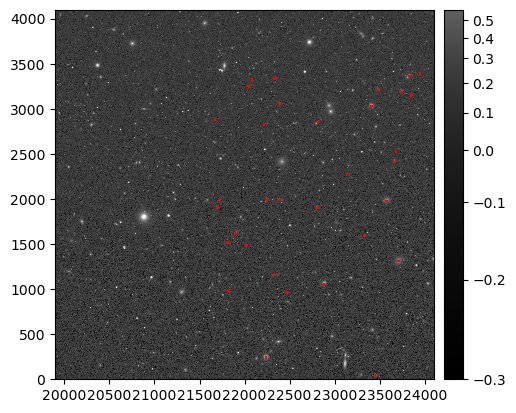

In [4]:
# prepare to do the cutout from tutorial notebook 03
config = 'dp02'
collection = '2.2i/runs/DP0.2'
butler = Butler.Butler(config, collections=collection)

datasetType = "deepCoadd"

dataId = {'tract': tab_maxblend['tract'][0], 'band': 'i', 'patch': tab_maxblend['patch'][0] }  
blend_coadd = butler.get(datasetType, **dataId)

deblend_metadata = butler.get("deblend_metadata", **dataId)

# Take a look at the image of the patch
plt.figure(figsize=(30,30))
afw_display = afwDisplay.Display()
afw_display.setMaskTransparency(100)
afw_display.scale('asinh', 'zscale')
afw_display.mtv(blend_coadd.getMaskedImage()) # what does getMaskedImage do?

# We use display buffering to avoid re-drawing the image
#  after each source is plotted
with afw_display.Buffering():
    for i in range(len(tab_maxblend)):
        afw_display.dot('+', tab_maxblend[i]['x'], tab_maxblend[i]['y'], ctype=afwDisplay.RED)

        #WTF IS GOING ON HERE WITH THE PLOTTING

In [5]:
%%time

#sel_objid = 1248675773246610542, tract 2897 and patch 5 is a good one
#1248675773246610542	23484.4969535	3210.1552014	50.1089143	-44.4812763	False	13	False	False	False	False	False	0	3435	0.0	2897	5
sel_objid = tab_maxblend[0]['objectId']
print(sel_objid)
query_children = "SELECT objectId, x, y, coord_ra, coord_dec, detect_isPrimary, deblend_nChild, deblend_skipped, detect_fromBlend, " + \
        "detect_isDeblendedModelSource, detect_isDeblendedSource, detect_isIsolated, parentObjectId, footprintArea, z_blendedness, " + \
        "tract, patch " + \
        "FROM dp02_dc2_catalogs.Object " + \
        "WHERE parentObjectID = " + str(sel_objid) + " AND " +\
        "tract = " + str(tab_maxblend[0]['tract']) + " AND patch = " + str(tab_maxblend[0]['patch']) # Number of children this object has (defaults to 0)

results_children = service.search(query_children)#, maxrec=max_rec)


# search for everything with parentobjID as one of these then you should get n_deblend sources.
# when talkign to data production: best to have a well constrained problem. here's this one thing
# here's what i'm trying to do, what is the next step. faster response this way.
# make a new notebook where i outline one source example. ask 1 question at a time. 10min

1248675773246610542
CPU times: user 9.12 ms, sys: 3.33 ms, total: 12.4 ms
Wall time: 16min 36s


In [6]:
tab_children = results_children.to_table()
tab_children 

objectId,x,y,coord_ra,coord_dec,detect_isPrimary,deblend_nChild,deblend_skipped,detect_fromBlend,detect_isDeblendedModelSource,detect_isDeblendedSource,detect_isIsolated,parentObjectId,footprintArea,z_blendedness,tract,patch
,pix,pix,deg,deg,,,,,,,,,pix,,,
int64,float64,float64,float64,float64,bool,int32,bool,bool,bool,bool,bool,int64,int32,float64,int64,int64
1248675773246640706,23512.9343389,3205.7072499,50.1066973,-44.4815091,True,0,False,True,True,True,False,1248675773246610542,3190,0.4453317,2897,5
1248675773246640705,23483.3200083,3246.0487119,50.1090308,-44.4792832,True,0,False,True,True,True,False,1248675773246610542,3658,0.1195687,2897,5
1248675773246640704,23466.9451452,3233.6287998,50.110297,-44.4799812,True,0,False,True,True,True,False,1248675773246610542,4329,0.0246939,2897,5
1248675773246640703,23484.4939823,3210.1595245,50.1089145,-44.481276,True,0,False,True,True,True,False,1248675773246610542,5840,-0.0120574,2897,5
1248675773246640715,23463.0054624,3244.5699979,50.1106113,-44.4793755,True,0,False,True,True,True,False,1248675773246610542,2388,0.8006751,2897,5
1248675773246640714,23503.2067846,3201.5918329,50.1074517,-44.4817425,True,0,False,True,True,True,False,1248675773246610542,2791,0.9565817,2897,5
1248675773246640713,23478.9219813,3227.3238199,50.1093602,-44.4803255,True,0,False,True,True,True,False,1248675773246610542,4270,1.0,2897,5
1248675773246640712,23465.7187079,3197.3916488,50.1103673,-44.4819947,True,0,False,True,True,True,False,1248675773246610542,3235,1.0,2897,5


In [7]:
sel_objid = tab_maxblend[0]['objectId']
sel_objid

1248675773246610542

<Figure size 3000x3000 with 0 Axes>

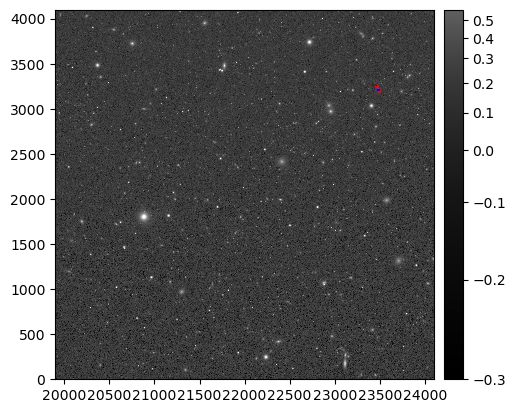

In [8]:
# Take a look at the image of the patch
plt.figure(figsize=(30,30))
afw_display = afwDisplay.Display()
afw_display.setMaskTransparency(100)
afw_display.scale('asinh', 'zscale')
afw_display.mtv(blend_coadd.getMaskedImage()) # what does getMaskedImage do?

# We use display buffering to avoid re-drawing the image
#  after each source is plotted
with afw_display.Buffering():
    for i in range(len(tab_children)):
        afw_display.dot('+', tab_children[i]['x'], tab_children[i]['y'], ctype=afwDisplay.RED)

afw_display.dot('+', tab_maxblend[0]['x'], tab_maxblend[0]['y'], ctype=afwDisplay.BLUE)

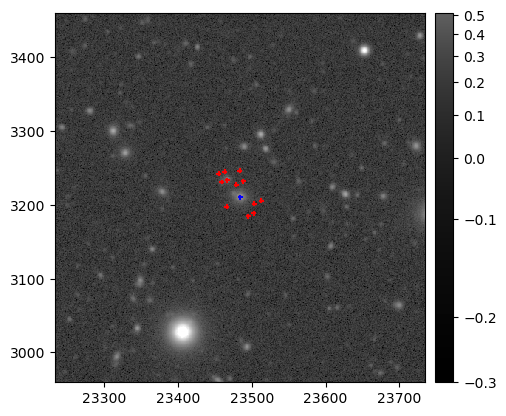

In [9]:
cutout_image = cutout_coadd(butler, tab_maxblend[0]['coord_ra'], tab_maxblend[0]['coord_dec'], band='i', datasetType='deepCoadd',
                            cutoutSideLength=501)

wcs = cutout_image.getWcs()

x0 = float(cutout_image.getX0())
y0 = float(cutout_image.getY0())
width = cutout_image.getWidth()
height = cutout_image.getHeight()

xcorners = [x0, x0+width, x0+width, x0]
ycorners = [y0, y0, y0+width, y0+width]

ra_corners = []
dec_corners = []

for i in range(len(xcorners)):
    radec = wcs.pixelToSky(xcorners[i], ycorners[i])
    ra_corners.append(radec.getRa().asDegrees())
    dec_corners.append(radec.getDec().asDegrees())


fig, ax = plt.subplots()
display = afwDisplay.Display(frame=fig)
display.scale('asinh', 'zscale')
display.mtv(cutout_image.image)
with display.Buffering():
    for i in range(len(tab_children)):
        display.dot('+', tab_children[i]['x'], tab_children[i]['y'], ctype=afwDisplay.RED)

display.dot('+', tab_maxblend[0]['x'], tab_maxblend[0]['y'], ctype=afwDisplay.BLUE)
plt.show()

In [10]:
print(tab_maxblend[0]['x'], tab_maxblend[0]['y'])


23484.4969535 3210.1552014


In [11]:
#below is junk to delete:

In [12]:
# First, pick a bunch of sources within a circular search radius around a galaxy cluster:

#dp

#center_coords = SkyCoord(55.6521739130, -31.9834710744, frame='icrs', unit='deg')
center_coords = SkyCoord(55.7393808,-32.2751775, frame='icrs', unit='deg')
search_radius = 10*u.arcmin

use_center_coords = "55.7393808, -32.2751775"
use_radius = "0.02"
 
max_rec = 10

query = "SELECT objectId, x, y, coord_ra, coord_dec, detect_isPrimary, deblend_nChild, deblend_skipped, detect_fromBlend, " + \
        "detect_isDeblendedModelSource, detect_isDeblendedSource, detect_isIsolated, parentObjectId " + \
        "FROM dp02_dc2_catalogs.Object " + \
        "WHERE CONTAINS(POINT('ICRS', coord_ra, coord_dec), " + \
        "CIRCLE('ICRS', " + use_center_coords + ", " + use_radius + ")) = 1 " + \
        "AND  detect_fromBlend = 1 " #This source is deblended from a parent with more than one child
        #"AND detect_isPrimary = 0 " #True if source has no children and is in the inner region of a coadd patch and is in the inner region of a coadd tract and is not detected in a pseudo-filter
        
results_notPrimary = service.search(query)#, maxrec=max_rec)
#assert len(results1) == max_rec

# Convert the results to an Astropy table, then
#   take a look at the table.
tab_notPrimary = results_notPrimary.to_table()
#tab_notPrimary 


In [13]:
query = "SELECT objectId, x, y, coord_ra, coord_dec, detect_isPrimary, deblend_nChild, deblend_skipped, detect_fromBlend, " + \
        "detect_isDeblendedModelSource, detect_isDeblendedSource, detect_isIsolated, parentObjectId " + \
        "FROM dp02_dc2_catalogs.Object " + \
        "WHERE CONTAINS(POINT('ICRS', coord_ra, coord_dec), " + \
        "CIRCLE('ICRS', " + use_center_coords + ", " + use_radius + ")) = 1 " + \
        "AND detect_isIsolated = 1"
#        "AND detect_isPrimary = 1 " # we want to remove this, make False to return blends

results_Isolated = service.search(query)#, maxrec=max_rec)
#assert len(results1) == max_rec

# Convert the results to an Astropy table, then
#   take a look at the table.
tab_Isolated = results_Isolated.to_table()
#tab_notPrimary 

In [14]:
query = "SELECT objectId, x, y, coord_ra, coord_dec, detect_isPrimary, deblend_nChild, deblend_skipped, detect_fromBlend, " + \
        "detect_isDeblendedModelSource, detect_isDeblendedSource, detect_isIsolated, parentObjectId " + \
        "FROM dp02_dc2_catalogs.Object " + \
        "WHERE CONTAINS(POINT('ICRS', coord_ra, coord_dec), " + \
        "CIRCLE('ICRS', " + use_center_coords + ", " + use_radius + ")) = 1 " + \
        "AND detect_isPrimary = 1 " # we want to remove this, make False to return blends

results_Primary = service.search(query)#, maxrec=max_rec)
#assert len(results1) == max_rec

# Convert the results to an Astropy table, then
#   take a look at the table.
tab_Primary = results_Primary.to_table()
#tab_notPrimary 

55.7506834813934 -32.28892993702273
The size of the cutout in pixels is:  (501, 501)


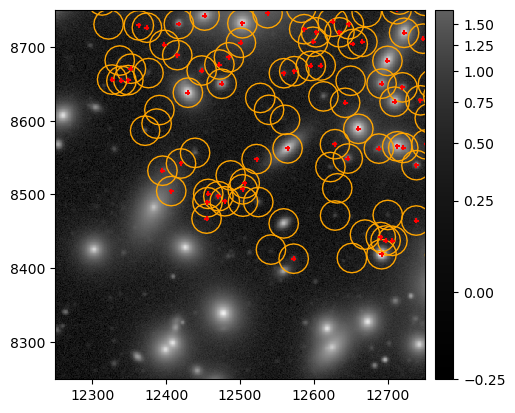

In [15]:
# prepare to do the cutout from tutorial notebook 03
config = 'dp02'
collection = '2.2i/runs/DP0.2'
butler = Butler.Butler(config, collections=collection)

dataId = {'tract': 4431, 'patch': 17, 'band': 'i'}
datasetType = 'deepCoadd'
# Retrieve the data using the `butler` instance and its function `get()`
coadd = butler.get(datasetType, **dataId)

# First, we need to extract the WCS solution, which provides the mapping
#   between XY pixel values and sky coordinates:
wcs = coadd.getWcs()

# The cluster seems to be centered at about (X, Y) ~ (12500, 8500).
# We can use the "pixelToSky" method of the WCS to get the sky coordinates:
radec = wcs.pixelToSky(12500, 8500)
ra, dec = radec.getRa().asDegrees(), radec.getDec().asDegrees()
print(ra, dec)

# Select a position at roughly the center of the galaxy cluster:
cutout_image = cutout_coadd(butler, ra, dec, band='i', datasetType='deepCoadd',
                            cutoutSideLength=501)
print("The size of the cutout in pixels is: ", cutout_image.image.array.shape)

# Display the image cutout
fig, ax = plt.subplots()
display = afwDisplay.Display(frame=fig)
display.scale('asinh', 'zscale')
display.mtv(cutout_image.image)

# We use display buffering to avoid re-drawing the image
#  after each source is plotted
with display.Buffering():
    for i in range(len(tab_notPrimary)):
        display.dot('+', tab_notPrimary[i]['x'], tab_notPrimary[i]['y'], ctype=afwDisplay.RED)
    for j in range(len(tab_Primary)):
        display.dot('o', tab_Primary[j]['x'], tab_Primary[j]['y'], size=20, ctype='orange')
    #for k in range(len(tab_Isolated)):
        #display.dot('^', tab_Isolated[k]['x'], tab_Isolated[k]['y'], ctype='blue')

plt.show()
#remove_figure(fig)

In [16]:
# get info about your cutout
refTable = butler.get('deepCoadd_ref',  tract=4431, patch=17)
refTable.schema.find('detect_isPrimary')
#refTable.schema.getNames()


SchemaItem(key=Key['Flag'](offset=1520, bit=26), field=Field['Flag'](name="detect_isPrimary", doc="true if source has no children and is in the inner region of a coadd patch and is in the inner region of a coadd tract and is not "detected" in a pseudo-filter (see config.pseudoFilterList)"))

In [17]:
# questions for melissa:
# - butler vs TAP for catalog access? when to use?
# butler is inefficient for catalog access because it returns all columns for everything in
# a track at once. This can be good for some circumstances, such as getting all objects
# inside an track/image. TAP is better for querying things that meet some criteria. 

# - is there a segmentation map somewhere that identifies the deblending mask?
# could be called "the footprint" see notebook 05 section 4. See also 
# https://github.com/LSSTScienceCollaborations/StackClub/blob/master/SourceDetection/Footprints.ipynb
# - Looks like detect_isDeblendedSource = 1 and detect_isPrimary = 1 return the same thing?

# action items:

# look in catalog and search for particular sources that have many blends (DP0.2 doesn't
# have low z big galaxies, only 6 years of data and also because cosmology focused 
# simulation).

# go through notebook5 and learn what it is doing. this will inform stretch activities
# for this notebook. We are not yet sure what the user-tunable parameters for the 
# deblender are, so we have to find them another way. Then we will have meeting with 
# Fred about deblender later. 

# scarlet is imbedded in lsst pipelines, but ALex's notebooks are a few years old so
# are many pipeline versions ago. It is now in the pipeline. I should not have to install
# it for myslef. Can look at what scarlet config params those old notebooks tweaked
# can be used to map into the lsst science pipeline framework (might be called something
# different etc).

# maybe (at the end) even re-run the deblender with different parameters (stretch goal)
# deblend is also done in notebook 05 but none of the parameters are changed. So here if 
# we get to the poitn where we can see what the user-changable parameters are, we could
# do a couple of demos. 

# in the geoviews jira ticket, just keep a log of what you did (i.e. can't find example
# of any astro applications of it). Since Keith (or Leanne?) suggested it we could also close the loop
# with him and ask if he had any examples in mind or has he seen it. Can a convenient
# astropy package for this already exist?

In [18]:
# Questions for Melissa week of Nov 8:
# - I think what I'm looking for here is what children belong to the same deblend.
# - cant figure out how to grab a set of blends from the same deblended object
# - can't figure out how to extract a footprint for a coadd without running the deblender again (see https://github.com/LSSTScienceCollaborations/StackClub/blob/master/SourceDetection/Footprints.ipynb)
# - what does getMaskedImage do?
# mask plane may contain (flags bad pixels, detection)
# - Struggling with accessing Footprint and MultibandFootprint (class in afw). How to use, are there leftover data products or does detection have to be run?
# in notebook 4b there's a way to say tell me everything accessible by butler. there are possibly no image metadata 
# avail from deepcoadd (since this product of deblender comes after deepcoadd is generated).
# deblend_metadata is a property set

# - what does AFW stand for? soemthing frameworks
# - 
#help(blend_coadd)
deblend_metadata = butler.get("deblend_metadata", **dataId)
deblend_metadata.

SyntaxError: invalid syntax (194441379.py, line 16)